# Aula - Árvores de Decisão para Regressão

- 1) Como adaptar o algoritmo das árvores de decisão para problemas de regressão?
- 2) Como avaliar meu modelo final de regressão? 

## 1) Árvores de Decisão para Regressão

Quando tínhamos o problema de classificação, nossa ideia era:<br>

> 1. Criar uma árvore de decisão em cima das minhas features e dos meus labels. <br>
> 2. Para decidir os splits automaticamente, usamos critérios de impureza (Gini, entropia)  <br>
> 3. A classe prevista para um novo caso é dada pela folha que o novo ponto irá cair depois de percorrer a árvore. A previsão será de acordo com a classe majoritária dessa folha. <br>

<br><br><br><br><br><br><br><br><br><br>

A gente pode adaptar essa ideia para __problemas de regressão__. <br>

> 1. Criar uma árvore de decisão em cima das minhas "features" e dos meus "labels". <br>
> 2. Para decidir os splits automaticamente, usamos o quanto teríamos de erro se parássemos naquele nó. <br>
> 3. O valor previsto para um novo caso é o valor médio da folha que o novo ponto irá cair. <br>

Tivemos então que adaptar 2 pontos importantes:
1. Como decidir o split da árvore
2. Como decidir o valor final do nó

Vamos ver com um exemplo como faríamos isso.

In [1]:
# importe as principais bibliotecas para ciência de dados
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Vamos começar pelo ponto 3:<br>
A gente vai assumir que o __valor previsto para uma dada região é a média dos valores dos pontos de treino que estavam naquela região__.

In [2]:
# Vamos pegar alguns pontos de exemplo
pontos = np.array([[1.0, 0.92],
                   [1.5, 0.51],
                   [2.0, -0.10],
                   [2.5, -0.02],
                   [3.0, 0.93],
                   [3.5, 2.18]])

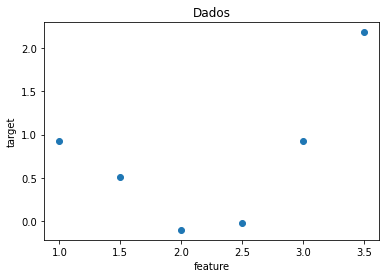

In [3]:
# Vamos desenhar eles, com um possível split inicial.
plt.title('Dados')
plt.scatter(pontos[:,0], pontos[:,1])
plt.xlabel('feature')
plt.ylabel('target')
plt.show()

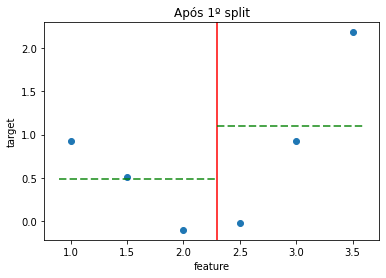

In [7]:
plt.title('Após 1º split')
plt.scatter(pontos[:,0], pontos[:,1])
plt.axvline(2.3, color='red')
plt.hlines(y=0.49, xmin=0.9, xmax=2.3, colors='green', linestyles='--', lw=2, label='1.55', alpha=0.7)
plt.hlines(y=1.1, xmin=2.3, xmax=3.6, colors='green', linestyles='--', lw=2, label='1.55', alpha=0.7)
plt.xlabel('feature')
plt.ylabel('target')
plt.show()

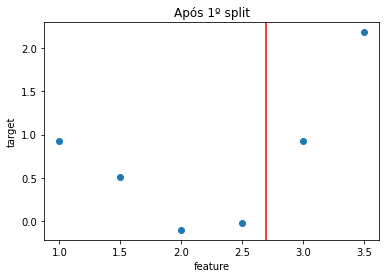

In [8]:
plt.title('Após 1º split')
plt.scatter(pontos[:,0], pontos[:,1])
plt.axvline(2.7, color='red')
plt.xlabel('feature')
plt.ylabel('target')
plt.show()

<font size=3> <b> Exercício 1: </b> </font>

1. Quais seriam os valores previstos do nó $ feature <= 2.7 $ (à esquerda da reta) se utilizássemos a média?
2. Quais seriam os valores previstos do nó $ feature > 2.7 $ (à esquerda da reta) se utilizássemos a média?
3. Esses valores previstos são bons? Como podemos fazer essa avaliação?
4. Qual era o melhor lugar para colocarmos aquela reta vermelha?
5. Onde você colocaria uma segunda quebra?
6. O que aconteceria com 5 quebras?
7. Como evitar esse problema?


Nossa função ficou da forma:

$$ y = \left\{
\begin{array}{ll}
    0.33 & , feature <= 2.7 \\
    1.55 & , feature > 2.7
\end{array} 
\right.  $$

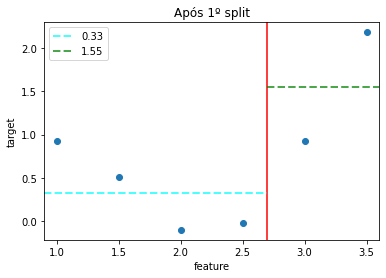

In [9]:
plt.title('Após 1º split')
plt.scatter(pontos[:,0], pontos[:,1])
plt.axvline(2.7, color='red')
plt.hlines(y=0.33, xmin=0.9, xmax=2.7, colors='aqua', linestyles='--', lw=2, label='0.33', alpha=0.7)
plt.hlines(y=1.55, xmin=2.7, xmax=3.6, colors='green', linestyles='--', lw=2, label='1.55', alpha=0.7)
plt.xlim([0.9, 3.6])
plt.xlabel('feature')
plt.ylabel('target')
plt.legend()
plt.show()

<br><br>

O que vamos fazer então é:
- Vamos escolher os splits que diminuíem a nossa métrica de erro
- Os valores que cada folha final da nossa árvore vai prever é a média de todos os pontos de treino que ficaram nela ao final.


Vamos considerar uma única feature gerada por uma função seno com ruído Gaussiano: se fizermos várias quebras na decision tree poderemos obter uma boa aproximação da curva real. 

<img src="images/decision-stump-1.png" style="width:400px" text="https://bradleyboehmke.github.io/HOML/DT.html">
<img src="images/decision-stump-2.png" style="width:400px" />

<br>
<img src="images/depth-3-decision-tree-1.png" style="width:400px" />
<img src="images/depth-3-decision-tree-2.png" style="width:400px" />
<br>
<img src="images/deep-overfit-tree-1.png" style="width:400px"/>
<img src="images/deep-overfit-tree-2.png" style="width:400px"/>

Isso nos leva à duas perguntas: 
* Como eu escolho qual é o melhor?
* Quando parar?

### Dataset

In [10]:
from sklearn.datasets import load_boston
dados = load_boston()
X = pd.DataFrame(data=dados['data'], columns=dados['feature_names'])
y = pd.Series(data=dados['target'],name='price')

/home/patricia/Documentos/LC/aula_venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the Cali

In [11]:
print(dados['DESCR'])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [12]:
y.describe()

count    506.000000
mean      22.532806
std        9.197104
min        5.000000
25%       17.025000
50%       21.200000
75%       25.000000
max       50.000000
Name: price, dtype: float64

In [13]:
# Sempre começar com a nossa famosa separação treino e validação
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                  test_size=0.3)

Agora vamos treinar nossa árvore de decisão para regressão
<br>
[sklearn.tree.DecisionTreeRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html)

In [17]:
# Importa algoritmo
from sklearn.tree import DecisionTreeRegressor

# Instanciar a classe do algoritmo
model_tree = DecisionTreeRegressor()

# Treina o modelo
model_tree.fit(X_train, y_train)

DecisionTreeRegressor()

In [19]:
# Faz predições no conjunto de validação
y_pred = model_tree.predict(X_val)

In [28]:
model_tree.feature_importances_

array([0.        , 0.        , 0.        , 0.        , 0.04114695,
       0.12893449, 0.        , 0.        , 0.        , 0.03572087,
       0.00310943, 0.        , 0.79108826])

In [29]:
X_train.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT'],
      dtype='object')

In [20]:
print(y_pred)

[19.9 36.2 24.4 20.3 14.4 21.9 34.7 31.7 18.3 24.3 20.1 21.4 27.5 22.6
 22.  15.6 23.1 18.5 19.5 43.1 28.5 22.2 20.5 11.3 30.1 12.5 22.6 18.2
 19.6 23.9  8.8 24.8 11.7 22.5 50.  24.4 19.2 17.3 22.  24.2 32.  32.
 19.3 24.7 50.  50.   8.4 16.7 22.2  7.2  7.2 23.2 16.2 18.5 27.1 17.8
 20.  16.6 31.6 16.2 19.  23.2 19.3 24.8 22.9 16.2 26.2 22.2 28.7 17.8
 17.9 22.2 19.2 22.  15.4 34.6 22.6 17.1 23.7 29.  15.6 37.6 43.1 27.1
 33.2 26.6 21.1 24.4 23.7 20.  13.   6.3 16.2 23.  14.5 21.6 12.6 27.9
 26.2 25.  20.4 14.9 30.1 24.3 24.5 24.2 19.2 48.5 16.2 18.3 18.2 23.7
 18.1 18.3 27.5 50.  21.2 18.6 21.6 36.4 15.6 20.8 29.8 29.6 33.8 21.1
 19.5 22.  17.9  8.8 22.5 20.4 10.2 33.2 15.6 15.6 50.  23.7 19.1 21.7
 14.8 22.2 23.1 11.3 19.4 13.5 13.8 16.2 18.4 27.9 33.8 22.1]


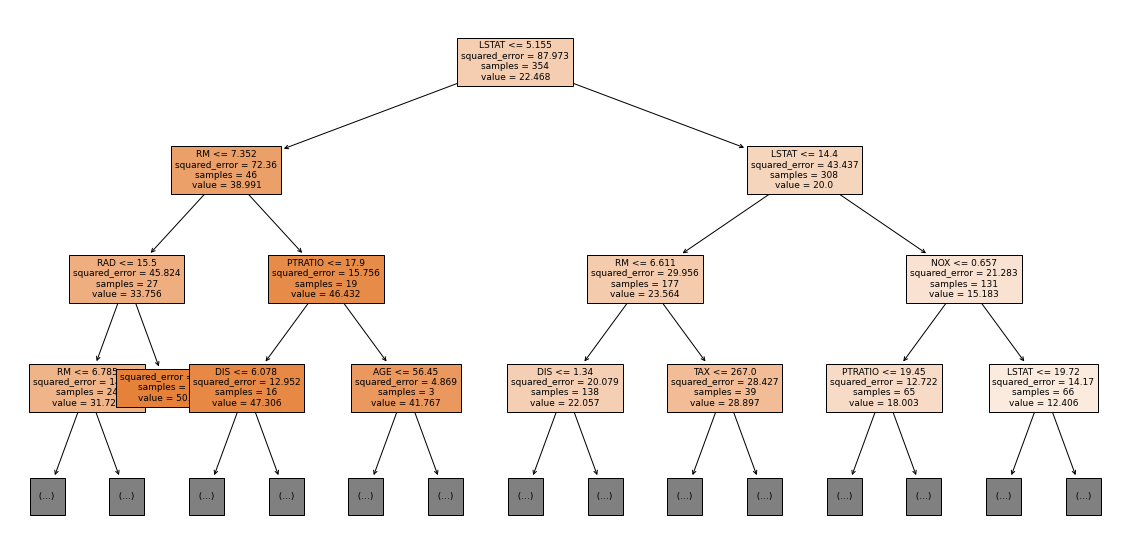

In [21]:
# Como ficou a árvore?
from sklearn.tree import plot_tree
plt.figure(figsize=(20, 10))
plot_tree(model_tree, feature_names=X_train.columns, max_depth=3, fontsize=9, filled=True)
plt.show()


LSTAT aparece bastante nas quebras né? Porque será?

In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Print das Métricas
print('Métricas para a Previsão:')
print('MAE:  ', np.round(mean_absolute_error(y_val, y_pred), decimals=3))
print('MSE:  ', np.round(mean_squared_error(y_val, y_pred), decimals=3))
print('RMSE: ', np.round(mean_squared_error(y_val, y_pred, squared=False), decimals=3))
print('R^2:  ', np.round(r2_score(y_val, y_pred), decimals=3))

Métricas para a Previsão:
MAE:   2.988
MSE:   18.313
RMSE:  4.279
R^2:   0.759


Text(0.5, 1.0, 'Comparação do valor predito com o real')

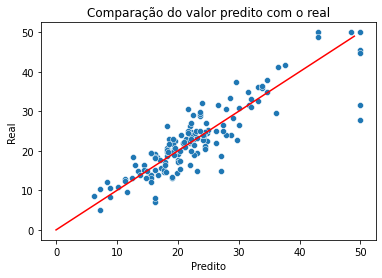

In [23]:
num_range = np.arange(0,50, 1)
sns.scatterplot(x = y_pred, y = y_val)
sns.lineplot(x=num_range, y=num_range, color='red', markers='-')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Comparação do valor predito com o real')

In [ ]:
# !pip install dtreeviz             # install dtreeviz for sklearn
# !pip install dtreeviz[xgboost]    # install XGBoost related dependency
# !pip install dtreeviz[pyspark]    # install pyspark related dependency
# !pip install dtreeviz[lightgbm]   # install LightGBM related dependency

In [ ]:
#! pip install dtreeviz

/home/patricia/Documentos/LC/aula_venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


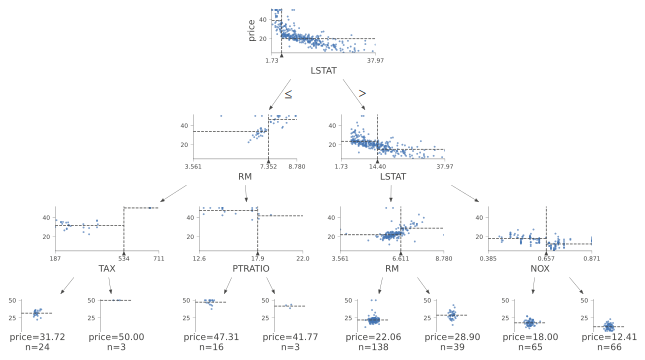

In [26]:
from dtreeviz.trees import dtreeviz

model_tree = DecisionTreeRegressor(max_depth=3)
model_tree.fit(X_train, y_train)

viz = dtreeviz(model_tree,
               X_train,
               y_train,
               target_name='price',
               feature_names=list(X_train.columns))

viz   

#### Prós e Contras

Prós: <br>
        * Capaz de lidar com variáveis categóricas e contínuas <br>
        * Geram regras de fácil compreensão para o negócio e é muito intuitivo <br>
        * Não necessita de normalização dos dados nem da escala ([Normalização x Escala](https://kharshit.github.io/blog/2018/03/23/scaling-vs-normalization))  <br>
        * Não é obrigatório tratar dados faltantes (no scikit learn é haha)<br>
        * Por isso tem um EDA mais fácil <br>
        * Pode capturar relações não lineares <br>
        * Traz uma ideia da importância de cada feature<br>
        * Pouco sensível à outliers

Contras: <br>
        * Pode ser instável com pequenas mudanças nos dados - alta variância (pode ser corrigido com métodos de bagging e boosting) <br>
        * Datasets desbalanceados podem gerar um viés (bias) <br>
        * Por vezes demora mais para ser treinado que outros modelos <br>
        * Precisa de mais tempo de treino conforme aumenta o número de features <br>
        * Features contínuas geram aumento do tempo de treino <br>
        * Tende ao Overfiting

<br>
https://www.educba.com/decision-tree-advantages-and-disadvantages/


### Como superar esses problemas?
Random Forest

## Exercício

Vamos testar usar nossas árvores de decisão de regressão para o conjunto de dados "Ames Housing". Esse é um conjunto com diversas vendas de casas realizadas em Ames - Iowa.

O objetivo é prever o valor da venda de uma casa (SalePrice) com base nas features escolhidas. O conjunto de dados já foi previamente separado em treino e teste. Assim, só precisa tomar cuidado em separar o treino da validação.

Objetivos:
> Compare a qualidade preditiva da árvore de decisão para três conjuntos diferentes de variáveis (estes conjuntos podem ter interseções, ou seja, variáveis em comum). 
> Compare qual melhor modelo, entre uma árvore de decisão e outro modelo de regressão.

## Bibliografia e aprofundamento
- [Métricas](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter)
- [Outras métricas](https://www.dataquest.io/blog/understanding-regression-error-metrics/) <br>
- [Scikit-Learn: Outras métricas de erro para regressão](https://scikit-learn.org/stable/modules/classes.html#regression-metrics) <br>
- [Biblioteca de visualização da árvore de decisão dtreeviz](https://github.com/parrt/dtreeviz) <br>
- [Visualização de árvores de decisão](https://mljar.com/blog/visualize-decision-tree/)
- [DT](https://www.cs.cornell.edu/courses/cs4780/2018fa/lectures/lecturenote17.html)
- [Are categorical variables getting lost in your random forests?](https://web.archive.org/web/20200924113639/https://roamanalytics.com/2016/10/28/are-categorical-variables-getting-lost-in-your-random-forests/)

<font size=5> <b> Tarefa: </b> </font>


Tente reproduzir o que fizemos aqui para outro modelo de regressão.

- As métricas melhoram ou pioram? <br>
- Olhando o RMSE, qual modelo você usaria? <br>
- Qual vai ser o RMSE no conjunto de testes? <br>

Nesse exemplo, temos uma Decision Tree aplicada em um dataset de preço de residências e, na folha mais à esquerda, foi aplicada uma regressão linear nos pontos para predizer o preço em vez de utilizar a média das amostras

<img src="images/lr+dt.png" />